# Multiparameter persistence introduction

In [1]:
import multipers as mp
import matplotlib.pyplot as plt
import numpy as np
import gudhi as gd

In [2]:
mp.simplex_tree_multi.SAFE_CONVERSION=False ## Enable this if you encounter crashes.

## Point clouds

### Robustness to noise

Let's start with a standard annulus. Adding a diffuse noise on a point cloud is known to be notoriously unstable w.r.t. persistence diagrams. We sampled here `1000` points on an annulus, aswell as `500` points on the square.

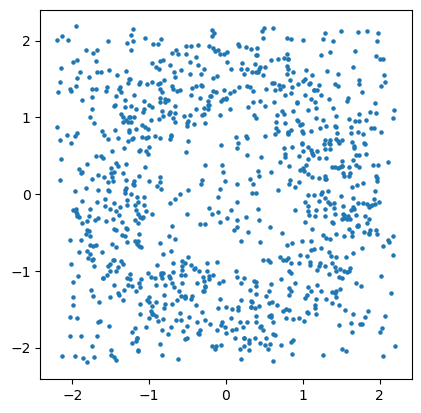

In [3]:
from multipers.data import noisy_annulus
X = noisy_annulus(n1=500, n2=500)
plt.scatter(X[:,0], X[:,1], s=5); plt.gca().set_aspect(1)

Without any surprise, the barcode associated with standard persistence cannot really retrieve the topology of the annulus

/home/dadou/micromamba/envs/311/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

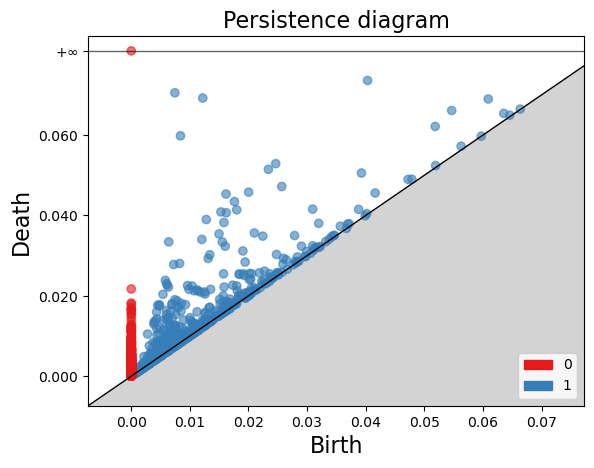

In [4]:
persistence = gd.AlphaComplex(points=X).create_simplex_tree().persistence()
gd.plot_persistence_diagram(persistence)

One way to deal with this issue is to take into account the sampling measure of the dataset; it is much more concentrated on the annulus than on the diffuse noise.

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


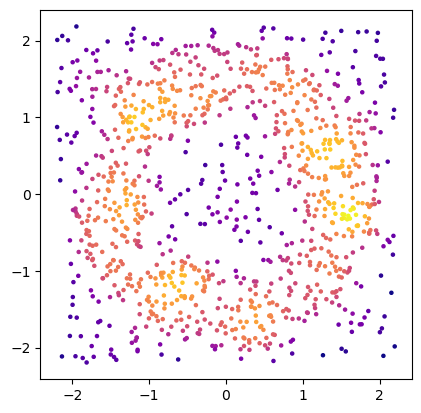

In [5]:
from multipers.ml.convolutions import KDE
density = KDE(bandwidth=0.2).fit(X).score_samples(X)
plt.scatter(X[:,0], X[:,1], s=5, c=np.exp(density), cmap="plasma"); plt.gca().set_aspect(1)

We then generate a 2-filtration, with first axis the rips radius, and the second axis given by the codensity, using the `RipsDensity2SimplexTree` pipeline.

In [6]:
import multipers.ml.point_clouds as mmp
# In practice, it is recommended to not use the sparse parameter, as there is not theoretical guarantees in this case.
(simplextree,), = mmp.PointCloud2SimplexTree(expand_dim=2,bandwidths=[0.2], num_collapses="full", sparse=.1, threshold=2.5, complex='rips').fit_transform([X])

A representation of the 2 persistence can be computed using interval decomposition technics, such as our `multiparameter_module_approximation` module. Here each interval, i.e., colored shape, visually correspond to the lifetime of a cycle in this 2-filtration. As you can see, there is one significant shape that stands out, which correspond to the annulus.

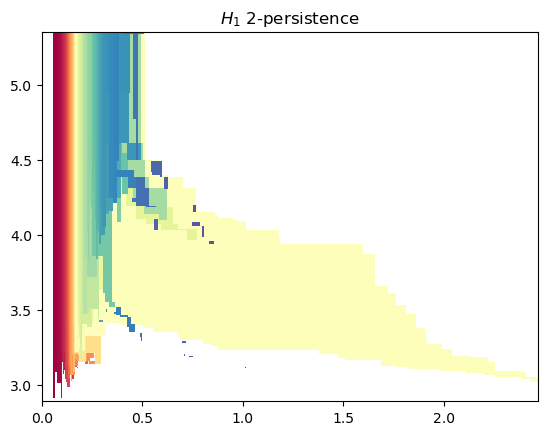

In [7]:
bimod = mp.module_approximation(simplextree)
bimod.plot(degree=1)

Although this structure is more visual, it can still be too expensive to compute depending on the usecase. On that end, the `hilbert signed measure` is another topological invariant, derived from the dimension vector of this 2-parameter module, which can be significantly faster to compute, depending on the parameters. In the following figure, each blue dot correspond to a *birthtime* and each red dot correspond to a *deathtime* in this 2-filtration.

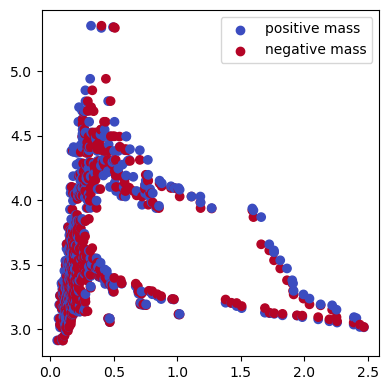

In [8]:
(pts,weights), = mp.signed_measure(simplextree, plot=True, degree=1)

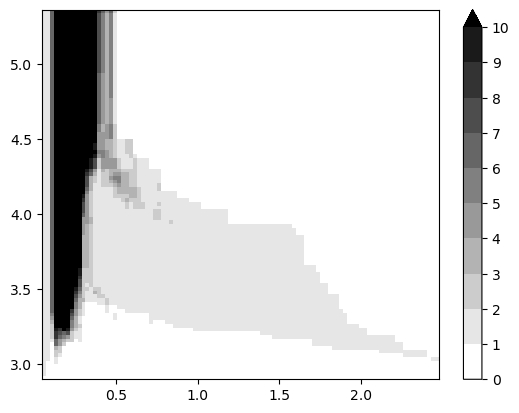

In [9]:
# one can recover the hilbert function, from the signed measure by integrating it as follows
import multipers.point_measure_integration
from multipers.plots import plot_surface
surface, grid =  mp.point_measure_integration.integrate_measure(pts,weights, return_grid=True)
plot_surface(grid, surface, discrete_surface=True)

Signed measures can also be computed from different topological invariant derived from a $n$-parameter persistence module, e.g., the *Euler characteristic*, which leads to the *Euler signed masure*. This one can be very fast to compute, but is not well suited to be used on point clouds, as it has to be computed on the full simplicial complex, i.e., using the simplices of all dimension, which can be prohibitive to store.

/home/dadou/micromamba/envs/311/lib/python3.11/site-packages/multipers/ml/signed_measures.py:227: UserWarning: This method ignores simplices of dimension > 1 !
  st.collapse_edges(full=True, max_dimension=1)


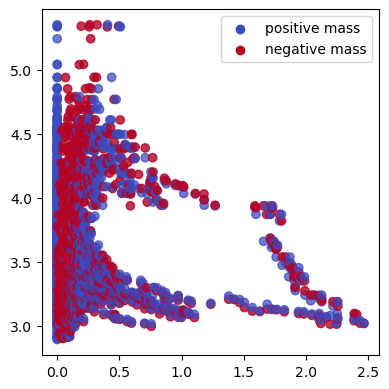

In [10]:
from multipers.ml.signed_measures import SimplexTree2SignedMeasure
sm, = SimplexTree2SignedMeasure(
	degrees=[None],
	plot=True,
	enforce_null_mass=False,
	expand=True, 
	grid_strategy='regular_closest', 
	resolution=1000, ## limits the grid to this resolution
	num_collapses='full'
).fit_transform([simplextree])

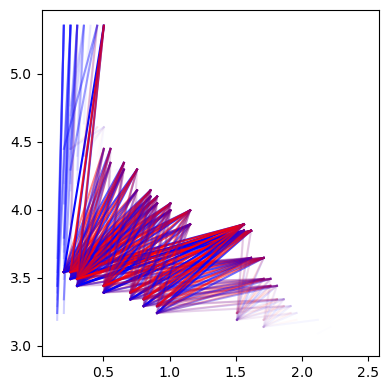

In [11]:
sm, = SimplexTree2SignedMeasure(
    degrees=[],
	rank_degrees=[1],
	plot=True,
	enforce_null_mass=False,
	expand=True, 
	grid_strategy='regular_closest', 
	resolution=50, ## limits the grid to this resolution
	num_collapses='full',
).fit_transform([simplextree])

### Taking into account the concentration of the sampling

We consider the same strategy as above but with another dataset. We will see that we are able to use the concentration of the sampling measure to our adventage.
<br>
Rips can become quite large on bigger datasets, so we will consider [Function Delaunay](https://arxiv.org/abs/2310.15902) bifiltrations instead, on which we compute minimal presentation to compute our invariants, with [mpfree](https://doi.org/10.1137/1.9781611976472.16).

You will need these two dependencies to execute the following code. [FunctionDelaunay](https://bitbucket.org/mkerber/function_delaunay) and [mpfree](https://bitbucket.org/mkerber/mpfree).

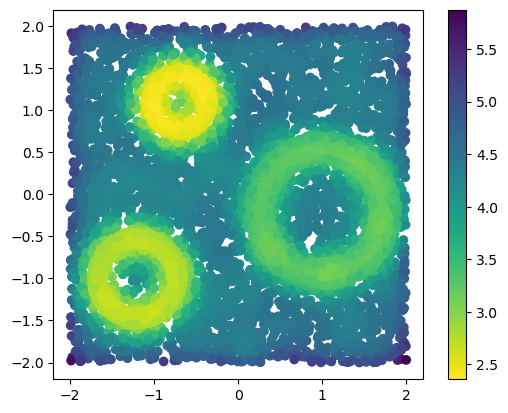

In [12]:
from multipers.data import three_annulus
X = three_annulus(5000,5000)
density = KDE(bandwidth=0.15).fit(X).score_samples(X)
plt.scatter(*X.T, c = -density, cmap="viridis_r")
plt.gca().set_aspect(1); plt.colorbar()

We first compute the Density-Delaunay bifiltration using

In [13]:
import multipers.slicer as mps
function_delaunay = mps.from_function_delaunay(X,-density) ## needs function_delaunay

On which we compute the minimal presentation of degree 1, using mpfree.

In [14]:
minimal_presentation = mps.minimal_presentation(function_delaunay, degree = 1, full_resolution=True, backend="mpfree") ## needs mpfree

There are different options there, but in this case we end up with a `Slicer` structure, which can be used to compute our previous invariant, in a much quicker way. 

As expected, we can clearly distinguish the 3 circles as the 3 big shapes in the figure below, and identify them using their radii. The surprising part is that multiparameter persistence also allows us to identify them using the **concentration** of their sampling ! This allows to retrieve much more information from the dataset :)
<br>
**Question:** Can you identify where is the 4th cycle in the original dataset ? 

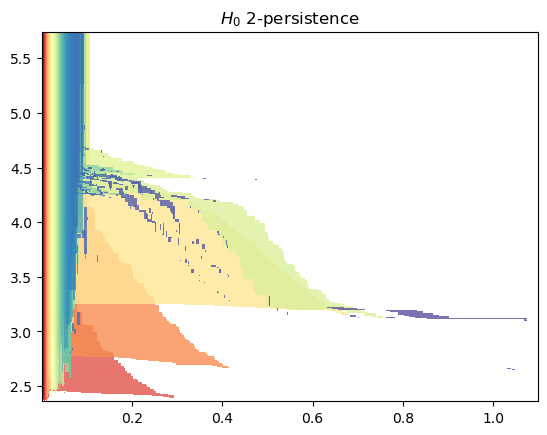

In [15]:
mp.module_approximation(minimal_presentation).plot(0, alpha=.8) # Plot takes a lot of time here, you can use `min_persistence` to speed it up

The Hilbert Signed measure can be directly retrieved from the slicer

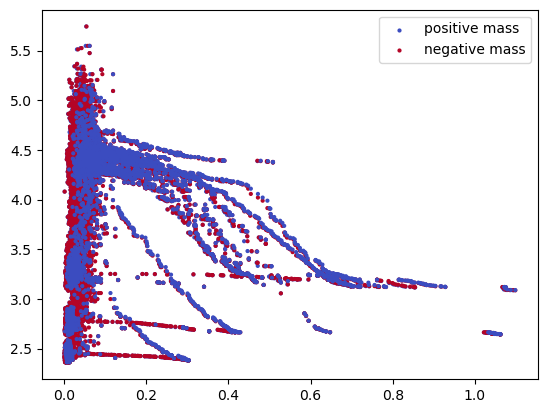

In [16]:
hilbert_sm, = mp.signed_measure(minimal_presentation)
mp.plots.plot_signed_measure(hilbert_sm, s=4)

The euler characteristic can be computed from the original function delaunay (with all of the simplices); although it's now quite a challenge to plot due to its size, so we'll only consider it's integration

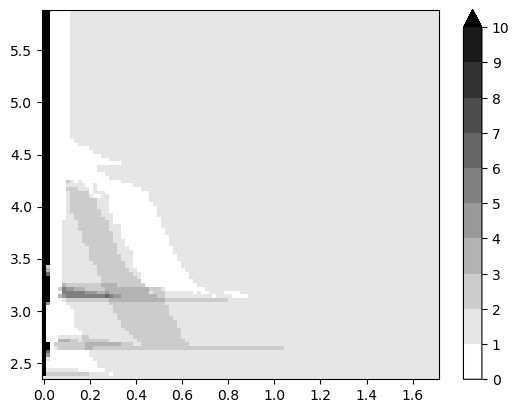

In [17]:
(pts,weights), = mp.signed_measure(function_delaunay)
euler_surface, grid =  mp.point_measure_integration.integrate_measure(pts,weights, return_grid=True, grid_strategy="regular", resolution=100)
plot_surface(grid, euler_surface, discrete_surface=True)

**Rank invariant is not available with this strategy yet.**

Note that signed measures can be easily turned into vectors using convolutions, via e.g., the `SignedMeasure2Convolution` class.

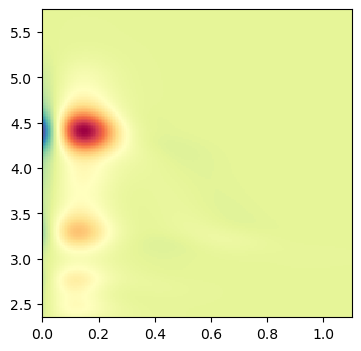

In [18]:
import multipers.ml.signed_measures as mms
img, = mms.SignedMeasure2Convolution(
    resolution=200, 
    grid_strategy="regular",
    bandwidth=.01,
    kernel='exponential',
    backend='pykeops',
    plot=True,
).fit_transform([[hilbert_sm]])

## Adding more parameters

### Graph classification

Some dataset comes with intrinsic values that can be used as filtrations, e.g., graphs, medical images, molecules. Multiparameter persistence is then very well suited to deal will all of this information **at once**. To bring this to light, we will consider the BZR graph dataset. It can be found [here](https://networkrepository.com/BZR.php).

In [19]:
import multipers.data.graphs as mdg
import multipers.ml.signed_measures as mms
import networkx as nx
from random import choice
from os.path import expanduser
dataset = "graphs/BZR"
path = mdg.DATASET_PATH+dataset
!ls $path ## We assume that the dataset is in this folder. You can modify the variable `mdg.DATASET_PATH` if necessary

BZR.edges      BZR.graph_labels  BZR.node_labels  graphs.pkl  mat
BZR.graph_idx  BZR.node_attrs	 BZR.readme	  labels.pkl  readme.html


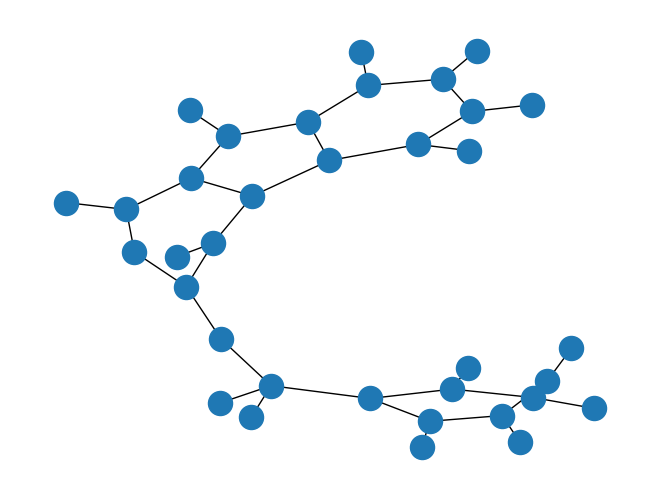

In [20]:
graphs, labels = mdg.get_graphs(dataset)
nx.draw(choice(graphs))

Graph dataset can be filtered by several filtration : node degrees, intrinsic values, ricci curvature, closeness centrality, heat kernel signature, etc.

In [21]:
## uncomment this line to compute filtrations on the graphs
# mdg.compute_filtration(dataset, filtration="ALL")
graphs, labels = mdg.get_graphs(dataset) # Retrieves these filtrations
g = graphs[0] # First graph of the dataset
g.nodes[0] # First node of the dataset, which holds several filtrations

{'intrinsic': array([-2.626347,  2.492403,  0.061623]),
 'geodesic': 0,
 'cc': 0.2116788321167883,
 'degree': 0.3333333333333333,
 'ricciCurvature': -0.33333333333333326,
 'fiedler': 0.03371256630833925,
 'hks_10': (0.1372184104225937+0j),
 'hks_1': 0.47648745932718856}

Similarly to the point clouds, we can create simplextrees, and turn them into signed measures

In [22]:
simplextrees = mdg.Graph2SimplexTrees(filtrations=["hks_10","degree","geodesic", "cc"]).fit_transform(graphs)

/home/dadou/micromamba/envs/311/lib/python3.11/site-packages/multipers/data/graphs.py:406: ComplexWarning: Casting complex values to real discards the imaginary part
  nodes_filtrations = np.asarray(
/home/dadou/micromamba/envs/311/lib/python3.11/site-packages/multipers/data/graphs.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  edges_filtrations = np.asarray(


In [23]:
signed_measures = mms.SimplexTrees2SignedMeasures(
	degrees=[0,1], n_jobs=-1, grid_strategy='exact', enforce_null_mass=True
).fit_transform(simplextrees) # None correspond to the euler characteristic, which is significantly faster to compute on graphs. 
# One may want to rescale filtrations w.r.t. each other. This can be done using the SignedMeasureFormatter class
signed_measures = mms.SignedMeasureFormatter(normalize=True, axis=0).fit_transform(signed_measures)

And finally classify these graphs using either a sliced wasserstein kernel, or a convolution.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from multipers.ml.kernels import DistanceMatrix2Kernel
## Split the data into train test
xtrain,xtest,ytrain,ytest = train_test_split(signed_measures, labels)
## Classification pipeline using the sliced wasserstein kernel
classifier = Pipeline([
    ("SWD",mms.SignedMeasure2SlicedWassersteinDistance(n_jobs=-1, num_directions=50)),
    ("KERNEL", DistanceMatrix2Kernel(sigma=1.)),
    ("SVM", SVC(kernel="precomputed")),
])
## Evaluates the classifier on this dataset. 
# Note that there is no cross validation here, so results can be significantly improved
classifier.fit(xtrain,ytrain).score(xtest,ytest)

0.803921568627451